# Simple Conv blur and Deconv unblur

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import numpy
import os
import matplotlib.pyplot as plt

## Import Image

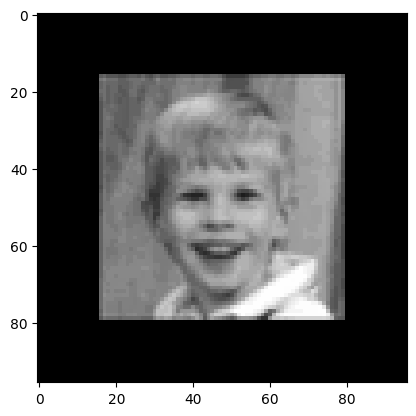

In [2]:
img_path = 'C:/Users/Rashaad/Downloads/kid_image.png'

img = keras.utils.load_img(img_path, color_mode='grayscale', target_size=(96, 96))
img = tf.keras.preprocessing.image.img_to_array(img)

plt.imshow(img, cmap='gray')
plt.show()

## Blur image with tf convolution function

In [3]:
def blur4f_img(kf, img):
    # img needs to be in form: (num_imgs x height x width x num_channels)
    img = tf.reshape(img, (1, img.shape[0], img.shape[1], 1)) 
    
    # kernel needs to be in form: (k_height x k_width x num_inputs x num_outputs)
    kf = tf.constant(kf)
    kf0 = tf.reshape(kf, (kf.shape[0], kf.shape[1], 1, 1))
    
    strides = [1, 1, 1, 1]
    
    img0 = tf.nn.conv2d(img, kf0, strides=strides, padding='SAME')
    img1 = tf.nn.conv2d(img0, tf.reverse(kf0, [0]), strides=strides, padding='SAME')
    img2 = tf.nn.conv2d(img1, tf.reverse(kf0, [1]), strides=strides, padding='SAME')
    img3 = tf.nn.conv2d(img2, tf.reverse(tf.reverse(kf0, [0]), [1]), strides=strides, padding='SAME')
    
    return img3

kf = tf.constant([[1.0, 0.2],
                 [0.5, 0.0]])

img_blur = blur4f_img(kf, img)

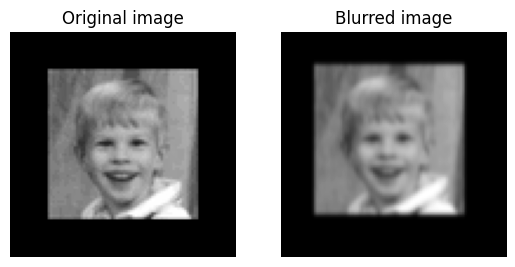

In [4]:
ax = plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
ax.set_title('Original image')
ax.axis('off')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_blur[0], cmap='gray')
ax.set_title('Blurred image')
ax.axis('off')

plt.show()

## Define DeconvLayer class in notebook

In [17]:
class DeconvDft2dLayer(layers.Layer):

    def __init__(self, h_shape, pad_amount=0.5, w=None):
        super(DeconvDft2dLayer, self).__init__()
        self.w = w
        self.h_shape = h_shape
        self.pad_amount = pad_amount

    def build(self, input_shape):
        # Initialise filter (w) except for the first element
        # So that first element is not trainable
        # Randomly initialise other components and multiply by factor of 1/2*sqrt(no. of pixels)
        if self.w == None:
            self.w = tf.random.uniform((1, self.h_shape[-2] * self.h_shape[-1] - 1))
            self.w = tf.Variable(self.w, trainable=True)

    def custom_op(self, xm):
        xm = tf.reshape(xm, (-1, xm.shape[-3], xm.shape[-2]))

        pad_w = tf.constant([[0, 0], [1, 0]])
        # Set first element to 1 then reshape into specified filter shape
        w0 = tf.pad(self.w, pad_w, mode='CONSTANT', constant_values=1)
        w0 = tf.reshape(w0, self.h_shape)
        
        print(self.w)

        padding = tf.constant(
            [[0, 0], [int(xm.shape[-2] * self.pad_amount), int(xm.shape[-2] * self.pad_amount)],
             [int(xm.shape[-1] * self.pad_amount), int(xm.shape[-1] * self.pad_amount)]])
        xm = tf.pad(xm, padding, "CONSTANT")

        paddings = tf.constant([[0, xm.shape[-2] - w0.shape[-2]], [0, xm.shape[-1] - w0.shape[-1]]])
        hm1 = tf.pad(w0, paddings, "CONSTANT")

        xm = tf.cast(xm, dtype=tf.complex64)
        hm1 = tf.cast(hm1, dtype=tf.complex64)

        gm1f = tf.divide(1, tf.signal.fft2d(hm1))
        gm2f = tf.roll(tf.reverse(gm1f, [0]), shift=1, axis=0)
        gm3f = tf.roll(tf.reverse(gm1f, [1]), shift=1, axis=1)
        gm4f = tf.roll(tf.reverse(gm3f, [0]), shift=1, axis=0)

        gmf1 = tf.multiply(gm1f, gm2f)
        gmf2 = tf.multiply(gm3f, gm4f)
        gmf = tf.multiply(gmf1, gmf2)

        ymf = tf.multiply(gmf, tf.signal.fft2d(xm))
        ym = tf.signal.ifft2d(ymf)
        ym = tf.cast(ym, dtype=tf.float32)

        ym = tf.reshape(ym, (-1, ym.shape[-2], ym.shape[-1], 1))
        # crop to original image size
        ym = tf.image.central_crop(ym, 1 / (1 + 2 * self.pad_amount))

        return ym

    def call(self, inputs):
        return self.custom_op(inputs)

## Unblur image with deconv layer

First we need to process the kernel to a format that the deconv layer uses

In [9]:
# We need to unroll the k because the kernel for deconv layer is a row vector
k_deconv = tf.reshape(kf, (1, -1))

# Now we need to take the first element out since deconv layer adds it automatically
k_deconv = k_deconv[:, 1:]
print(k_deconv)

tf.Tensor([[0.2 0.5 0. ]], shape=(1, 3), dtype=float32)


Now we can create an instance of the deconv layer and set the kernel to `k_deconv`

tf.Tensor([[0.2 0.5 0. ]], shape=(1, 3), dtype=float32)
tf.Tensor([[0.2 0.5 0. ]], shape=(1, 3), dtype=float32)


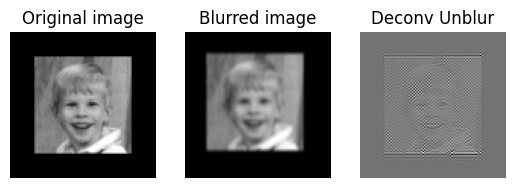

In [18]:
deconv = DeconvDft2dLayer((2, 2), w = k_deconv)
# deconv.w = k_deconv

print(deconv.w)

img_unblur = deconv(img)

ax = plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
ax.set_title('Original image')
ax.axis('off')

ax = plt.subplot(1, 3, 2)
plt.imshow(img_blur[0], cmap='gray')
ax.set_title('Blurred image')
ax.axis('off')

ax = plt.subplot(1, 3, 3)
plt.imshow(img_unblur[0], cmap='gray')
ax.set_title('Deconv Unblur')
ax.axis('off')

plt.show()